Catboost - tabular - sentiment

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2022-11-10 04:08:26.347293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 04:08:26.538370: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 04:08:27.167878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


2022-11-10 04:08:28.109895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 04:08:32.693823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 27480 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-10 04:08:32.695977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 33659 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-11-10 04:08:32.697918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 33659 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capab

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time

from catboost import CatBoostClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

!pip install ipywidgets
!pip install catboost
import ipywidgets
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
%cd ..

/workspace/asurion_f22


In [6]:
test = pd.read_csv('fe_data/fe_data_v2/total_sale_data/test_encoded_zipcode.csv', index_col='id')

In [7]:
sen_test = pd.read_csv('fe_data/sentiment_data/sentiment_test.csv')

In [8]:
len(test)

258459

In [9]:
test.columns

Index(['quality_sale', 'accepted_flg', 'seven_day_churn', 'thirty_day_churn',
       'ninety_day_churn', 'clndr_dt_cst', 'start_dt', 'lines',
       'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count',
       'num_decline', 'exp', 'product_type', 'pmake', 'claritas_hh_count',
       'technodoption_class', 'hh_income', 'age_class', 'hh_education',
       'hh_composition', 'hh_tenure', 'urbanicity', 'median_income',
       'total_population', 'perc_female', 'perc_under18', 'perc_over65',
       'perc_white', 'perc_black', 'population_density', 'zipcode', 'county',
       'state', 'state_code', 'latitude', 'longitude', 'month',
       'hh_income_code', 'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [10]:
dcols = ['accepted_flg', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'month','hh_income_code']

In [11]:
test.drop(columns = dcols, inplace = True)
test = test[(test['zipcode_accepted_prop'].isnull()==False)& (test['zipcode_rejected_offers'].isnull()==False)& 
            (test['zipcode_accepted_offers'].isnull()==False)&(test['zipcode_total_offers'].isnull()==False)]

In [12]:
test = test.merge(sen_test, on='id', how='inner')

In [13]:
len(test)

144064

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144064 entries, 0 to 144063
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          144064 non-null  object 
 1   quality_sale                144064 non-null  int64  
 2   seven_day_churn             12942 non-null   float64
 3   thirty_day_churn            12942 non-null   float64
 4   ninety_day_churn            12942 non-null   float64
 5   lines                       144064 non-null  int64  
 6   previous_tech_support_call  144064 non-null  int64  
 7   account_tenure              144064 non-null  int64  
 8   past_yr_claim_count         144064 non-null  int64  
 9   num_decline                 144064 non-null  int64  
 10  exp                         144064 non-null  int64  
 11  product_type                144064 non-null  object 
 12  pmake                       144064 non-null  object 
 13  claritas_hh_co

In [15]:
train = pd.read_csv('fe_data/fe_data_v2/total_sale_data/train_encoded_zipcode.csv', index_col='id')

In [16]:
sen_train = pd.read_csv('fe_data/sentiment_data/sentiment_train.csv')

In [17]:
len(train)

953112

In [18]:
len(train)

953112

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 953112 entries, c90ce3eaafffd07a32cb9cf4d153aef6f524b29aeef447ba3200efdb to 66b4c3759f378f38589395fd0353856239da965077903f31b30e87fc
Data columns (total 45 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   quality_sale                953112 non-null  int64  
 1   accepted_flg                953112 non-null  int64  
 2   seven_day_churn             85707 non-null   float64
 3   thirty_day_churn            85707 non-null   float64
 4   ninety_day_churn            85707 non-null   float64
 5   clndr_dt_cst                953112 non-null  object 
 6   start_dt                    953112 non-null  object 
 7   lines                       953112 non-null  int64  
 8   previous_tech_support_call  953112 non-null  int64  
 9   account_tenure              953112 non-null  int64  
 10  past_yr_claim_count         953112 non-null  int64  
 11  num_decline                 95

In [20]:
train.head()

,quality_sale,accepted_flg,seven_day_churn,thirty_day_churn,ninety_day_churn,clndr_dt_cst,start_dt,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,zipcode,county,state,state_code,latitude,longitude,month,hh_income_code,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c90ce3eaafffd07a32cb9cf4d153aef6f524b29aeef447ba3200efdb,0,0,NaN,NaN,NaN,2022-03-21 00:00:00.000,2022-03-21 20:44:17.405,2,15,1286,2,3,1,SD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,134658,13596,47,13,37,91,0,0,85266.00,Scottsdale,Arizona,AZ,33.77,-111.92,march,1,Monday,20,0.05,55.00,3.00,58.00
91aa94d54079b20e2a18b09c070d0304b3df9c7272e9fc75470cb2ff,0,0,NaN,NaN,NaN,2022-03-03 00:00:00.000,2022-03-03 21:16:27.713,1,10,216,5,13,1,SD,android,2507965,High-Tech,3 Upper Midscale,2 Middle Age,2 College Graduate,1 w/ Kids,1 Homeowners,8 Mix,56714,30122,52,24,16,57,34,616,21801.00,Salisbury,Maryland,MD,38.38,-75.63,march,3,Thursday,21,0.10,110.00,12.00,122.00
eb269842f94437bfd7e3a5a1f30d7b9a84a842afd8a153e8788c0d45,0,0,NaN,NaN,NaN,2022-03-16 00:00:00.000,2022-03-16 13:59:15.707,5,30,6559,0,11,1,MD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,130557,33039,49,28,9,64,6,2232,91354.00,Valencia,California,CA,34.45,-118.54,march,1,Wednesday,13,0.06,103.00,7.00,110.00
fc05f45119a8a4b830a3463bfc8a7113b2807c88e7d2da0320e559df,0,0,NaN,NaN,NaN,2022-03-01 00:00:00.000,2022-03-01 12:33:55.917,5,1,3944,0,0,1,MD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,116157,51830,50,19,21,20,0,1507,96744.00,Kaneohe,Hawaii,HI,21.42,-157.81,march,1,Tuesday,12,0.10,78.00,9.00,87.00
68943556bf63277816d843ffb129e23ffe60bc5b982603ec9519659a,1,1,0.00,0.00,0.00,2022-03-01 00:00:00.000,2022-03-01 12:22:15.780,2,4,689,1,8,1,SD,android,1715961,High-Tech,4 Midscale,1 Younger,3 Some College,1 w/ Kids,5 Renters,7 Metro Mix,49842,34512,48,27,9,74,11,1894,77301.00,Conroe,Texas,TX,30.31,-95.45,march,4,Tuesday,12,0.19,57.00,13.00,70.00


In [21]:
len(train)

953112

In [22]:
train.drop(columns = dcols, inplace = True)
train = train[(train['zipcode_accepted_prop'].isnull()==False)& (train['zipcode_rejected_offers'].isnull()==False)& 
            (train['zipcode_accepted_offers'].isnull()==False)&(train['zipcode_total_offers'].isnull()==False)]

In [23]:
train = train.merge(sen_train, on='id', how='inner')

In [24]:
len(train)

708693

In [25]:
train.columns

Index(['id', 'quality_sale', 'seven_day_churn', 'thirty_day_churn',
       'ninety_day_churn', 'lines', 'previous_tech_support_call',
       'account_tenure', 'past_yr_claim_count', 'num_decline', 'exp',
       'product_type', 'pmake', 'claritas_hh_count', 'technodoption_class',
       'hh_income', 'age_class', 'hh_education', 'hh_composition', 'hh_tenure',
       'urbanicity', 'median_income', 'total_population', 'perc_female',
       'perc_under18', 'perc_over65', 'perc_white', 'perc_black',
       'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [26]:
test.columns

Index(['id', 'quality_sale', 'seven_day_churn', 'thirty_day_churn',
       'ninety_day_churn', 'lines', 'previous_tech_support_call',
       'account_tenure', 'past_yr_claim_count', 'num_decline', 'exp',
       'product_type', 'pmake', 'claritas_hh_count', 'technodoption_class',
       'hh_income', 'age_class', 'hh_education', 'hh_composition', 'hh_tenure',
       'urbanicity', 'median_income', 'total_population', 'perc_female',
       'perc_under18', 'perc_over65', 'perc_white', 'perc_black',
       'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [27]:
test["previous_tech_support_call"] = test["previous_tech_support_call"].astype(int)
test["num_decline"] = test["num_decline"].astype(int)
test["exp"] = test["exp"].astype(int)
test["claritas_hh_count"] = test["claritas_hh_count"].astype(int)
test["time_of_day"] = test["time_of_day"].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144064 entries, 0 to 144063
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          144064 non-null  object 
 1   quality_sale                144064 non-null  int64  
 2   seven_day_churn             12942 non-null   float64
 3   thirty_day_churn            12942 non-null   float64
 4   ninety_day_churn            12942 non-null   float64
 5   lines                       144064 non-null  int64  
 6   previous_tech_support_call  144064 non-null  int64  
 7   account_tenure              144064 non-null  int64  
 8   past_yr_claim_count         144064 non-null  int64  
 9   num_decline                 144064 non-null  int64  
 10  exp                         144064 non-null  int64  
 11  product_type                144064 non-null  object 
 12  pmake                       144064 non-null  object 
 13  claritas_hh_co

In [28]:
def transform_xy(dat):
    X_ori = dat[[
#         'emplid','cvp_call_id',
                 'lines', 'previous_tech_support_call','account_tenure', 'past_yr_claim_count', 
                'num_decline', 'exp', 
#                  'churn',
                 'product_type', 'pmake', 
                 'claritas_hh_count',
                 'technodoption_class', 'hh_income', 'age_class', 'hh_education',
                 'hh_composition', 'hh_tenure', 'urbanicity','median_income', 'total_population', 
                 'perc_female', 'perc_under18',
                'perc_over65', 'perc_white', 'perc_black', 'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers', 'sentiment']]
    y = dat[['quality_sale']]
   
    X_ori.loc[X_ori.lines.isnull(), 'lines'] = 0
    X_ori.exp = X_ori.exp.apply(int)
    X_ori.num_decline = X_ori.num_decline.apply(float)
    X_ori.loc[X_ori.account_tenure.isnull(), 'account_tenure'] = 0
    X_ori.loc[X_ori.claritas_hh_count.isnull(), 'claritas_hh_count'] = 0
    X_ori.loc[X_ori.exp.isnull(), 'exp'] = 'Unknown'
    X_ori.loc[X_ori.product_type.isnull(), 'product_type'] = 'Unknown'
    X_ori.loc[X_ori.pmake.isnull(), 'pmake'] = 'Unknown'
    X_ori.loc[X_ori.technodoption_class.isnull(), 'technodoption_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_income.isnull(), 'hh_income'] = 'Unknown'
    X_ori.loc[X_ori.age_class.isnull(), 'age_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_education.isnull(), 'hh_education'] = 'Unknown'
    X_ori.loc[X_ori.hh_composition.isnull(), 'hh_composition'] = 'Unknown'
    X_ori.loc[X_ori.hh_tenure.isnull(), 'hh_tenure'] = 'Unknown'
    X_ori.loc[X_ori.urbanicity.isnull(), 'urbanicity'] = 'Unknown'
    X_ori.loc[X_ori.day_of_week.isnull(), 'day_of_week'] = 'Unknown'
    X_ori.loc[X_ori.time_of_day.isnull(), 'time_of_day'] = 'Unknown'
    X_ori.loc[X_ori.zipcode_accepted_prop.isnull(), 'zipcode_accepted_prop'] = 0
    X_ori.loc[X_ori.zipcode_rejected_offers.isnull(), 'zipcode_rejected_offers'] = 0
    X_ori.loc[X_ori.zipcode_accepted_offers.isnull(), 'zipcode_accepted_offers'] = 0
    X_ori.loc[X_ori.zipcode_total_offers.isnull(), 'zipcode_total_offers'] = 0
    X_ori.loc[X_ori.median_income.isnull(), 'median_income'] = 0
    X_ori.loc[X_ori.total_population.isnull(), 'total_population'] = 0
    X_ori.loc[X_ori.perc_female.isnull(), 'perc_female'] = 0
    X_ori.loc[X_ori.perc_under18.isnull(), 'perc_under18'] = 0
    X_ori.loc[X_ori.perc_over65.isnull(), 'perc_over65'] = 0
    X_ori.loc[X_ori.perc_white.isnull(), 'perc_white'] = 0
    X_ori.loc[X_ori.perc_black.isnull(), 'perc_black'] = 0
    X_ori.loc[X_ori.population_density.isnull(), 'population_density'] = 0
    X_ori.loc[X_ori.previous_tech_support_call.isnull(), 'previous_tech_support_call'] = "Unknown"
    X_ori.loc[X_ori.sentiment.isnull(), 'sentiment'] = "Unknown"
    

    return X_ori,y

In [29]:
X,y = transform_xy(train)
x_hold_out, y_hold_out = transform_xy(test)

In [30]:
X['lines'] = X['lines'].astype(np.int) 
X['previous_tech_support_call'] = X['previous_tech_support_call'].astype('category')
X['num_decline'] = X['num_decline'].astype(np.int) 
X['past_yr_claim_count'] = X['past_yr_claim_count'].astype(np.int) 
X['exp'] = X['exp'].astype('category') 
X['account_tenure'] = X['account_tenure'].astype(np.int) 
X['pmake'] = X['pmake'].astype('category')
X['technodoption_class'] = X['technodoption_class'].astype('category')
X['claritas_hh_count'] = X['claritas_hh_count'].astype('category')
X['hh_income'] = X['hh_income'].astype('category')
X['age_class'] = X['age_class'].astype('category')
X['hh_education'] = X['hh_education'].astype('category')
X['hh_composition'] = X['hh_composition'].astype('category')
X['hh_tenure'] = X['hh_tenure'].astype('category')
X['urbanicity'] = X['urbanicity'].astype('category')
X['product_type'] = X['product_type'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['zipcode_accepted_prop'] = (X['zipcode_accepted_prop']*100).astype(np.int)
X['zipcode_rejected_offers'] = X['zipcode_rejected_offers'].astype(np.int)
X['zipcode_accepted_offers'] = X['zipcode_accepted_offers'].astype(np.int)
X['zipcode_total_offers'] = X['zipcode_total_offers'].astype(np.int)


X['median_income'] = X['median_income'].astype(np.int)
X['total_population'] = X['total_population'].astype(np.int)
X['perc_female'] = X['perc_female'].astype(np.int)
X['perc_under18'] = X['perc_under18'].astype(np.int)
X['perc_over65'] = X['perc_over65'].astype(np.int)
X['perc_white'] = X['perc_white'].astype(np.int)
X['perc_black'] = X['perc_black'].astype(np.int)
X['population_density'] = X['population_density'].astype(np.int)
X['sentiment'] = X['sentiment'].astype('category')

In [31]:
x_hold_out['lines'] = x_hold_out['lines'].astype(np.int) 
x_hold_out['previous_tech_support_call'] = x_hold_out['previous_tech_support_call'].astype('category')
x_hold_out['num_decline'] = x_hold_out['num_decline'].astype(np.int) 
x_hold_out['past_yr_claim_count'] = x_hold_out['past_yr_claim_count'].astype(np.int) 
x_hold_out['exp'] = x_hold_out['exp'].astype('category') 
x_hold_out['account_tenure'] = x_hold_out['account_tenure'].astype(np.int) 
x_hold_out['pmake'] = x_hold_out['pmake'].astype('category')
x_hold_out['technodoption_class'] = x_hold_out['technodoption_class'].astype('category')
x_hold_out['claritas_hh_count'] = x_hold_out['claritas_hh_count'].astype('category')
x_hold_out['hh_income'] = x_hold_out['hh_income'].astype('category')
x_hold_out['age_class'] = x_hold_out['age_class'].astype('category')
x_hold_out['hh_education'] = x_hold_out['hh_education'].astype('category')
x_hold_out['hh_composition'] = x_hold_out['hh_composition'].astype('category')
x_hold_out['hh_tenure'] = x_hold_out['hh_tenure'].astype('category')
x_hold_out['urbanicity'] = x_hold_out['urbanicity'].astype('category')
x_hold_out['product_type'] = x_hold_out['product_type'].astype('category')
x_hold_out['day_of_week'] = x_hold_out['day_of_week'].astype('category')
x_hold_out['time_of_day'] = x_hold_out['time_of_day'].astype('category')
x_hold_out['zipcode_accepted_prop'] = (x_hold_out['zipcode_accepted_prop']*100).astype(np.int)
x_hold_out['zipcode_rejected_offers'] = x_hold_out['zipcode_rejected_offers'].astype(np.int)
x_hold_out['zipcode_accepted_offers'] = x_hold_out['zipcode_accepted_offers'].astype(np.int)
x_hold_out['zipcode_total_offers'] = x_hold_out['zipcode_total_offers'].astype(np.int)


x_hold_out['median_income'] = x_hold_out['median_income'].astype(np.int)
x_hold_out['total_population'] = x_hold_out['total_population'].astype(np.int)
x_hold_out['perc_female'] = x_hold_out['perc_female'].astype(np.int)
x_hold_out['perc_under18'] = x_hold_out['perc_under18'].astype(np.int)
x_hold_out['perc_over65'] = x_hold_out['perc_over65'].astype(np.int)
x_hold_out['perc_white'] = x_hold_out['perc_white'].astype(np.int)
x_hold_out['perc_black'] = x_hold_out['perc_black'].astype(np.int)
x_hold_out['population_density'] = x_hold_out['population_density'].astype(np.int)
x_hold_out['sentiment'] = x_hold_out['sentiment'].astype('category')

In [32]:
X.head()

,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers,sentiment
0,1,10,216,5,13,1,SD,android,2507965,High-Tech,3 Upper Midscale,2 Middle Age,2 College Graduate,1 w/ Kids,1 Homeowners,8 Mix,56714,30122,52,24,16,57,34,616,Thursday,21,9,110,12,122,negative
1,5,30,6559,0,11,1,MD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,130557,33039,49,28,9,64,6,2232,Wednesday,13,6,103,7,110,positive
2,5,1,3944,0,0,1,MD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,116157,51830,50,19,21,20,0,1507,Tuesday,12,10,78,9,87,neutral
3,2,4,689,1,8,1,SD,android,1715961,High-Tech,4 Midscale,1 Younger,3 Some College,1 w/ Kids,5 Renters,7 Metro Mix,49842,34512,48,27,9,74,11,1894,Tuesday,12,18,57,13,70,positive
4,5,2,1369,0,5,1,MD,android,2693700,Mid-Tech,3 Upper Midscale,3 Older,2 College Graduate,5 w/o Kids,2 Mostly Owners,7 Metro Mix,100645,36460,48,20,15,81,0,225,Monday,16,6,140,10,150,positive


In [33]:
len(x_hold_out)

144064

In [34]:
len(X)

708693

In [35]:
len(y)

708693

In [36]:
type(train)

pandas.core.frame.DataFrame

In [37]:
type(test)

pandas.core.frame.DataFrame

In [38]:
len(test)

144064

In [39]:
len(x_hold_out)

144064

In [40]:
len(y_hold_out)

144064

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708693 entries, 0 to 708692
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   lines                       708693 non-null  int64   
 1   previous_tech_support_call  708693 non-null  category
 2   account_tenure              708693 non-null  int64   
 3   past_yr_claim_count         708693 non-null  int64   
 4   num_decline                 708693 non-null  int64   
 5   exp                         708693 non-null  category
 6   product_type                708693 non-null  category
 7   pmake                       708693 non-null  category
 8   claritas_hh_count           708693 non-null  category
 9   technodoption_class         708693 non-null  category
 10  hh_income                   708693 non-null  category
 11  age_class                   708693 non-null  category
 12  hh_education                708693 non-null  category
 13 

In [42]:
x_hold_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144064 entries, 0 to 144063
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   lines                       144064 non-null  int64   
 1   previous_tech_support_call  144064 non-null  category
 2   account_tenure              144064 non-null  int64   
 3   past_yr_claim_count         144064 non-null  int64   
 4   num_decline                 144064 non-null  int64   
 5   exp                         144064 non-null  category
 6   product_type                144064 non-null  category
 7   pmake                       144064 non-null  category
 8   claritas_hh_count           144064 non-null  category
 9   technodoption_class         144064 non-null  category
 10  hh_income                   144064 non-null  category
 11  age_class                   144064 non-null  category
 12  hh_education                144064 non-null  category
 13 

In [43]:
Xf_train, Xf_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify=y['quality_sale'])

In [44]:
Xf_train.columns

Index(['lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [45]:
Xf_test.columns

Index(['lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [46]:
y_train.value_counts()

quality_sale
0               448524
1                47561
dtype: int64

In [47]:
train_census_dataset = cb.Pool(Xf_train,y_train, 
                        cat_features=np.where(Xf_train.dtypes != np.int)[0])                                                      
test_census_dataset = cb.Pool(Xf_test, y_test,           
                       cat_features=np.where(Xf_test.dtypes != np.int)[0])

In [48]:
holdout_census_dataset = cb.Pool(x_hold_out, y_hold_out,           
                       cat_features=np.where(x_hold_out.dtypes != np.int)[0])

In [49]:
spw = (y_train['quality_sale'] == 0.00).sum()/(y_train['quality_sale'] == 1.00).sum()
spw

9.430499779230882

In [50]:
from catboost import CatBoostClassifier

In [51]:
#initiate model
cat_model_census = CatBoostClassifier(
    cat_features = np.where(Xf_train.dtypes != np.int)[0],
    scale_pos_weight=spw,
    max_depth = 7,
    learning_rate = 0.05
)
#train
cat_model_census.fit(train_census_dataset, 
       eval_set=test_census_dataset,
      plot=True, silent= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [52]:
pred_census = cat_model_census.predict_proba(holdout_census_dataset)
threshold=0.5
predicted_cat_census = (pred_census[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_hold_out, predicted_cat_census).ravel()
print("catboost_holdout_set",'\n',
    "recall:",recall_score(y_hold_out, predicted_cat_census),'\n',
     'precision',precision_score(y_hold_out, predicted_cat_census),'\n',
     confusion_matrix(y_hold_out, predicted_cat_census),'\n',
     'f1 score:',f1_score(y_hold_out, predicted_cat_census),'\n',
     'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_holdout_set 
 recall: 0.5440013049506566 
 precision 0.11863683255665042 
 [[82251 49552]
 [ 5591  6670]] 
 f1 score: 0.19479286830308254 
 tn:82251, fp:49552, fn:5591, tp:6670 



In [53]:
pred_census = cat_model_census.predict_proba(test_census_dataset)
threshold=0.5
predicted_cat_census = (pred_census[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_test, predicted_cat_census).ravel()
print("catboost_testset",'\n',
    "recall:",recall_score(y_test, predicted_cat_census),'\n',
     'precision',precision_score(y_test, predicted_cat_census),'\n',
     confusion_matrix(y_test, predicted_cat_census),'\n',
     'f1 score:',f1_score(y_test, predicted_cat_census),'\n',
     'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_testset 
 recall: 0.7015159691900112 
 precision 0.16683195463720263 
 [[120815  71410]
 [  6084  14299]] 
 f1 score: 0.26955849639935153 
 tn:120815, fp:71410, fn:6084, tp:14299 



In [54]:
vip = cat_model_census.feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':Xf_train.columns, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(15)

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
zipcode_accepted_offers,37.82,37.82,1.00
zipcode_accepted_prop,15.50,15.50,1.00
lines,7.01,7.01,1.00
zipcode_rejected_offers,4.93,4.93,1.00
zipcode_total_offers,4.53,4.53,1.00
num_decline,4.01,4.01,1.00
product_type,3.53,3.53,1.00
account_tenure,2.97,2.97,1.00
previous_tech_support_call,2.05,2.05,1.00


In [55]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


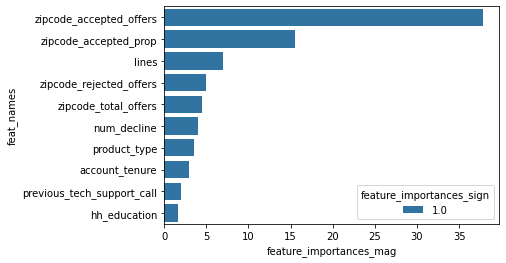

In [56]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);

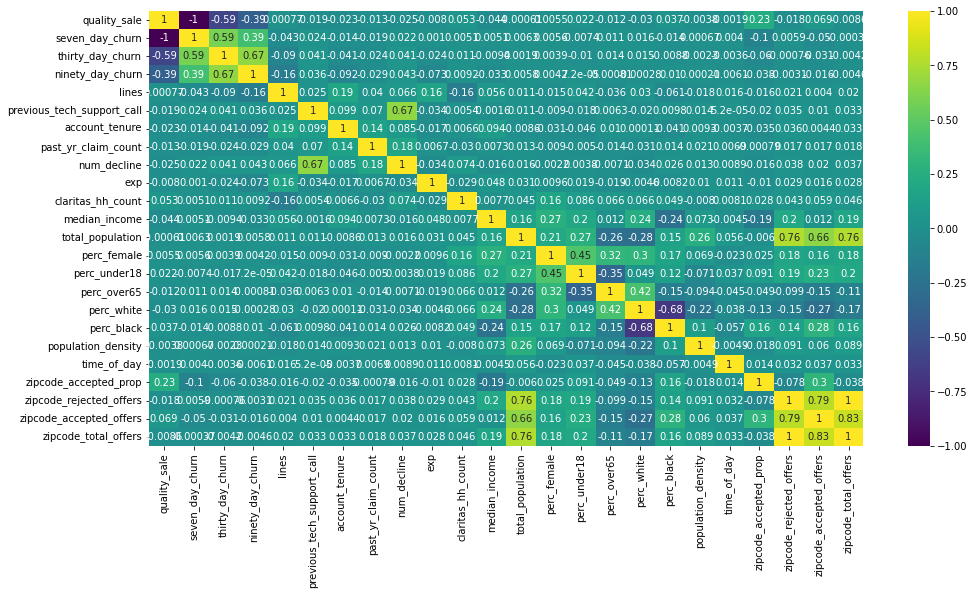

In [57]:
plt.figure(figsize = (16,8))
cor = train.corr()
sns.heatmap(cor, annot = True, cmap = "viridis")
plt.show()